# MNIST Classification using CNN
The task at hand involves creating a Convolutional Neural Network (CNN) to perform classification on the MNIST digit dataset. This dataset encompasses various handwritten digits, and the ultimate objective is to construct a specialized model capable of accurately recognizing these handwritten digits, essentially resulting in a proficient handwritten digit recognition system.

## Model Basics

### Importing the libraries

In [1]:
import numpy as np
import torch
import matplotlib.pylab as plt
import math
import random

import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.utils.data import random_split, Subset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch.autograd import Variable
import torch.optim as optim
from torchsummary import summary

from sklearn.metrics import confusion_matrix
import seaborn as sns
from time import time

### Loading the data and creating batches

In [2]:
complete_train_data = dsets.MNIST(root = './data', train = True, transform = transforms.ToTensor(), target_transform=lambda x : nn.functional.one_hot(torch.tensor([x]),10), download = True)

train_data, val_data = random_split(complete_train_data, [50000, 10000])
test_data = dsets.MNIST(root = './data', train = False, transform = transforms.ToTensor(), target_transform=lambda x : nn.functional.one_hot(torch.tensor([x]),10), download = True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [3]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=1, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=False)

In [4]:
image, label = test_data[0]
torch.squeeze(image).shape

torch.Size([28, 28])

In [5]:
label

tensor([[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]])

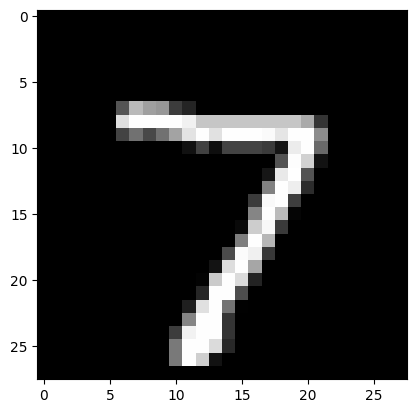

In [6]:
plt.imshow(torch.squeeze(image),cmap='gray')

### Building the Model with the given specifications

In [7]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 32, 3, stride=1, padding=1) #out dim = 28*28*32
    self.pool1 = nn.MaxPool2d(2, stride=2) #out dim = 14*14*32
    self.conv2 = nn.Conv2d(32, 32, 3, stride=1, padding=1) #out dim = 14*14*32
    self.pool2 = nn.MaxPool2d(2, stride=2) #out dim = 7*7*32
    self.fc1 = nn.Linear(32*7*7, 500)
    self.fc2 = nn.Linear(500, 10)

  def forward(self, x):
    x = self.pool1(F.relu(self.conv1(x)))
    x = self.pool2(F.relu(self.conv2(x)))
    x = torch.flatten(x, 1) # flatten all dimensions except batch
    x = self.fc1(x)
    x = self.fc2(x)
    return x

net = Net()

In [8]:
# Defining a loss function and optimiser
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

## 1. Training the model on the training data while tracking the training and validation loss

In [9]:
epochs = 15
iter_list=[]
loss_list = []
val_iter_list=[]
val_loss_list = []
iter = 0
val_iter = 0

running_loss = 0

for j in range(epochs):  # loop over the dataset multiple times
    print("Epoch = ",j)

    # val loss
    val_running_loss = 0
    with torch.no_grad():
        for data in val_loader:
            val_iter+=1
            val_image, val_label = data
            val_output = net(val_image)
            val_loss = criterion(val_output.squeeze(), torch.squeeze(val_label).float())
            val_running_loss += val_loss.item()
            if (val_iter%500 == 0):
                val_iter_list.append(val_iter)
                val_loss_list.append(val_running_loss/500)
                val_running_loss = 0.0

    for batch in train_loader:
        iter = iter+1
        loss=0
        image,labels = batch

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(image) #torch.argmax(net(inputs))

        loss = criterion(outputs, torch.squeeze(labels).float())
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if (iter%64 == 0 or iter%782 == 0):
            if (iter%64 == 0):
                den = 64
            else:
                den = 14
            iter_list.append(iter)
            print("Iteration = ",iter)
            loss_list.append(running_loss/den)
            print("Loss = ",running_loss/den)
            running_loss = 0.0

Epoch =  0
Iteration =  64
Loss =  0.8192042044829577
Iteration =  128
Loss =  0.20164638356072828
Iteration =  192
Loss =  0.16674179656547494
Iteration =  256
Loss =  0.13962396295391954
Iteration =  320
Loss =  0.09124559245537966
Iteration =  384
Loss =  0.11106250283773988
Iteration =  448
Loss =  0.07501792385301087
Iteration =  512
Loss =  0.0939046840503579
Iteration =  576
Loss =  0.08450699617969804
Iteration =  640
Loss =  0.07036563979636412
Iteration =  704
Loss =  0.06849187509942567
Iteration =  768
Loss =  0.0717042723117629
Iteration =  782
Loss =  0.07333723029920033
Epoch =  1
Iteration =  832
Loss =  0.04331549332709983
Iteration =  896
Loss =  0.0660519185312296
Iteration =  960
Loss =  0.07003289216663688
Iteration =  1024
Loss =  0.057410895635257475
Iteration =  1088
Loss =  0.06092119825189002
Iteration =  1152
Loss =  0.058515363008154964
Iteration =  1216
Loss =  0.05592103352682898
Iteration =  1280
Loss =  0.05439579565791064
Iteration =  1344
Loss =  0.041

### Plot of Training Loss versus Iterations

Text(0.5, 1.0, 'Training Loss vs Iterations')

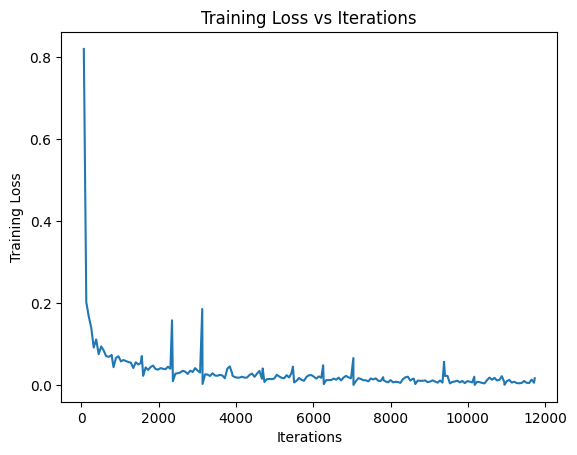

In [10]:
#plotting the training loss vs iterations
plt.plot(iter_list,loss_list)

plt.xlabel('Iterations')
plt.ylabel('Training Loss')
plt.title('Training Loss vs Iterations')

### Plot of Validation Loss versus Iterations

Text(0.5, 1.0, 'Validation Loss vs Iterations')

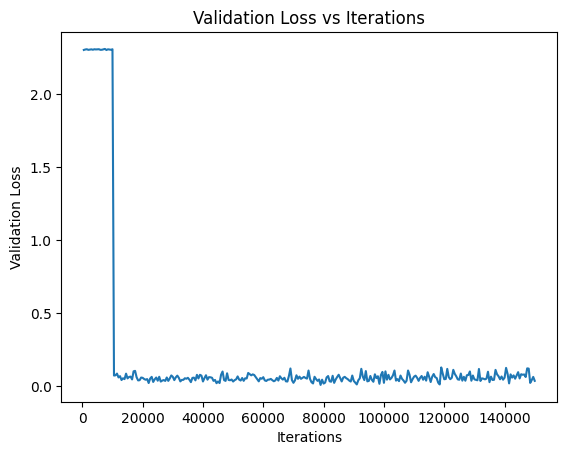

In [11]:
#plotting the validation loss vs iterations
plt.plot(val_iter_list,val_loss_list)

plt.xlabel('Iterations')
plt.ylabel('Validation Loss')
plt.title('Validation Loss vs Iterations')

### Training accuracy of the model

In [12]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in train_loader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        predicted = torch.argmax(outputs, dim=1, keepdim=True)
        actual = torch.argmax(torch.squeeze(labels), dim=1, keepdim=True)
        total += labels.size(0)
        correct += (predicted == actual).sum().item()

print(f'Accuracy of the network on the 50000 training images: {100 * correct / total} %')

Accuracy of the network on the 50000 training images: 99.762 %


### Average prediction accuracy on the test data

In [13]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)

        # the class with the highest energy is what we choose as prediction
        predicted = torch.argmax(outputs, dim=1, keepdim=True)
        actual = torch.argmax(labels, dim=1, keepdim=True)
        total += labels.size(0)
        correct += (predicted == actual).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct / total} %')

Accuracy of the network on the 10000 test images: 98.2 %


## 2. Predicted output versus the actual output for 10 randomly selected images

### Creating a subset of 10 randomly selected images

In [14]:
random_indices = random.sample(range(len(test_data)), 10)
sampler = SubsetRandomSampler(random_indices)
subset_loader = DataLoader(test_data, batch_size=1, sampler=sampler)

### Plotting the actual labels and the predicted values for these 10 images

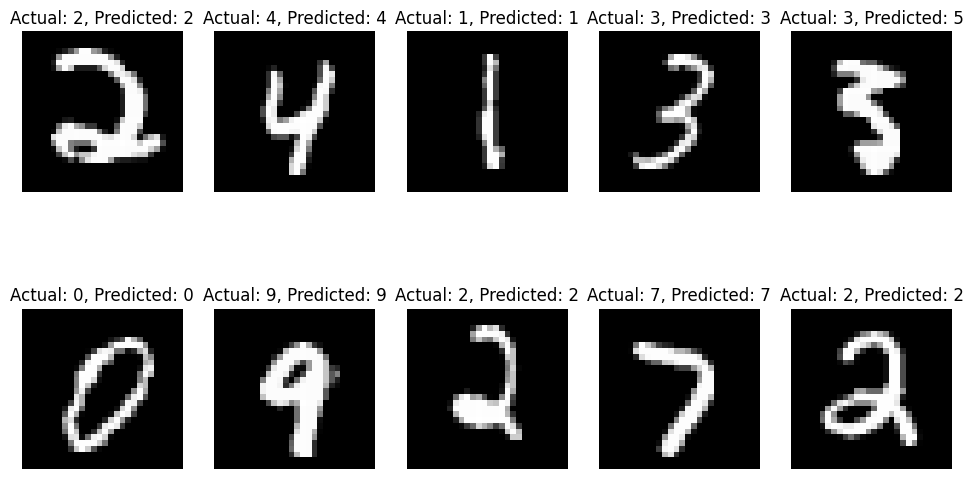

In [15]:
all_images = []
all_actual_labels = []
all_predicted_labels = []

with torch.no_grad():
    for data in subset_loader:
        images, labels = data

        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        predicted = torch.argmax(outputs).item()
        actual = torch.argmax(labels).item()

        all_images.append(torch.squeeze(images))
        all_actual_labels.append(actual)
        all_predicted_labels.append(predicted)

fig, axs = plt.subplots(2, 5, figsize=(12, 6))
fig.subplots_adjust(hspace=0.5)

for i in range(10):
    ax = axs[i // 5, i % 5]
    ax.imshow(all_images[i], cmap='gray')
    ax.set_title(f"Actual: {all_actual_labels[i]}, Predicted: {all_predicted_labels[i]}")
    ax.axis('off')

plt.show()

## 3. Reporting the dimensions of input and output at each layer

### Plotting Model Summary

In [16]:
summary(net, (1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 32, 28, 28]          320
├─MaxPool2d: 1-2                         [-1, 32, 14, 14]          --
├─Conv2d: 1-3                            [-1, 32, 14, 14]          9,248
├─MaxPool2d: 1-4                         [-1, 32, 7, 7]            --
├─Linear: 1-5                            [-1, 500]                 784,500
├─Linear: 1-6                            [-1, 10]                  5,010
Total params: 799,078
Trainable params: 799,078
Non-trainable params: 0
Total mult-adds (M): 2.82
Input size (MB): 0.00
Forward/backward pass size (MB): 0.24
Params size (MB): 3.05
Estimated Total Size (MB): 3.29


Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 32, 28, 28]          320
├─MaxPool2d: 1-2                         [-1, 32, 14, 14]          --
├─Conv2d: 1-3                            [-1, 32, 14, 14]          9,248
├─MaxPool2d: 1-4                         [-1, 32, 7, 7]            --
├─Linear: 1-5                            [-1, 500]                 784,500
├─Linear: 1-6                            [-1, 10]                  5,010
Total params: 799,078
Trainable params: 799,078
Non-trainable params: 0
Total mult-adds (M): 2.82
Input size (MB): 0.00
Forward/backward pass size (MB): 0.24
Params size (MB): 3.05
Estimated Total Size (MB): 3.29

The input to the first layer is (1,28,28), and for every subsequent layer, the input will be the output of the previous layer

From the output of the previous cell, we have obtained the shapes of the outputs from each layer

## 4. Reporting the network Parameters

For the parameters, we notice that the convolutional neural network has a total of 9568 parameters with biases and the fully connected layers have a total of 789510 parameters

## 5. Reporting the number of neurons in the Model

To determine the number of neurons in the neural network, we can count them based on the architecture you provided:

1. **Convolutional Layers:**
    - Input Layer: This layer has 28x28 input from the image. So, the number of neurons in this layer is 28 x 28 = 784 neurons.
    - Convolutional Layer 1: This layer has 32 output channels (feature maps) with a size of 28x28 after padding. So, the number of neurons in this layer is 32 x 28 x 28 = 25088 neurons.
    - Convolutional Layer 2: This layer also has 32 output channels and the same spatial size of 14x14. So, the number of neurons in this layer is 32 x 14 x 14 = 6,272 neurons.
2. **Fully Connected Layers (Linear Layers):**
    - Fully Connected Layer 1: This layer has 500 neurons.
    - Output Layer 2: This layer has 10 neurons (assuming it's the output layer for classification, where each neuron represents a class).

To summarize:

- The convolutional layers contribute 784+25,088 + 6272 = 32144 neurons.
- The fully connected layers contribute 500 + 10 = 510 neurons.

So, the neural network has a total of 32144 + 510 = 32654 neurons.

Note that we are not including the pooling layer as neurons as we can consider the weights connecting the maximum value from each kernel in conv1 to conv2 as having some value, and the remaining weights as 0

## 6. Model with batch normalization

### Building the model

In [17]:
class Batch_Norm_Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 32, 3, stride=1, padding=1) #out dim = 28*28*32
    self.bn1 = nn.BatchNorm2d(32)
    self.pool1 = nn.MaxPool2d(2, stride=2) #out dim = 14*14*32
    self.conv2 = nn.Conv2d(32, 32, 3, stride=1, padding=1) #out dim = 14*14*32
    self.bn2 = nn.BatchNorm2d(32)
    self.pool2 = nn.MaxPool2d(2, stride=2) #out dim = 7*7*32
    self.fc1 = nn.Linear(32*7*7, 500)
    self.fc2 = nn.Linear(500, 10)

  def forward(self, x):
    x = self.bn1(F.relu(self.conv1(x)))
    x = self.pool1(x)
    x = self.bn2(F.relu(self.conv2(x)))
    x = self.pool2(x)
    x = torch.flatten(x, 1) # flatten all dimensions except batch
    x = self.fc1(x)
    x = self.fc2(x)
    return x

batch_net = Batch_Norm_Net()

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(batch_net.parameters(), lr=0.001)

### Training the model

In [19]:
epochs = 15
iter_list=[]
loss_list = []
val_iter_list=[]
val_loss_list = []
iter = 0
val_iter = 0

for j in range(epochs):  # loop over the dataset multiple times
    print("Epoch = ",j)

    # val loss
    val_running_loss = 0
    with torch.no_grad():
        for data in val_loader:
            val_iter+=1
            val_image, val_label = data
            val_output = batch_net(val_image)
            val_loss = criterion(val_output.squeeze(), torch.squeeze(val_label).float())
            val_running_loss += val_loss.item()
            if (val_iter%500 == 0):
                val_iter_list.append(val_iter)
                val_loss_list.append(val_running_loss/500)
                val_running_loss = 0.0

    for batch in train_loader:
        iter = iter+1
        loss=0
        image,labels = batch

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = batch_net(image) #torch.argmax(net(inputs))

        loss = criterion(outputs, torch.squeeze(labels).float())
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if (iter%64 == 0 or iter%782 == 0):
            if (iter%64 == 0):
                den = 64
            else:
                den = 14
            iter_list.append(iter)
            print("Iteration = ",iter)
            loss_list.append(running_loss/den)
            print("Loss = ",running_loss/den)
            running_loss = 0.0

Epoch =  0
Iteration =  64
Loss =  0.46721409328165464
Iteration =  128
Loss =  0.1547309352317825
Iteration =  192
Loss =  0.12679396837484092
Iteration =  256
Loss =  0.1255790547511424
Iteration =  320
Loss =  0.11211204970823019
Iteration =  384
Loss =  0.09667778098082636
Iteration =  448
Loss =  0.06977751518934383
Iteration =  512
Loss =  0.08533691147749778
Iteration =  576
Loss =  0.09491322913891054
Iteration =  640
Loss =  0.08952307815343374
Iteration =  704
Loss =  0.10225409487247816
Iteration =  768
Loss =  0.08696503291866975
Iteration =  782
Loss =  0.07793879931393478
Epoch =  1
Iteration =  832
Loss =  0.049222719768295065
Iteration =  896
Loss =  0.062187408986574155
Iteration =  960
Loss =  0.0529509023308492
Iteration =  1024
Loss =  0.0561320259380409
Iteration =  1088
Loss =  0.07707771093009796
Iteration =  1152
Loss =  0.07166330151449074
Iteration =  1216
Loss =  0.07668673169791873
Iteration =  1280
Loss =  0.08386734328814782
Iteration =  1344
Loss =  0.051

Let us now visualise the same parameters as the previous model

### Training Loss vs Iterations

Text(0.5, 1.0, 'Training Loss vs Iterations')

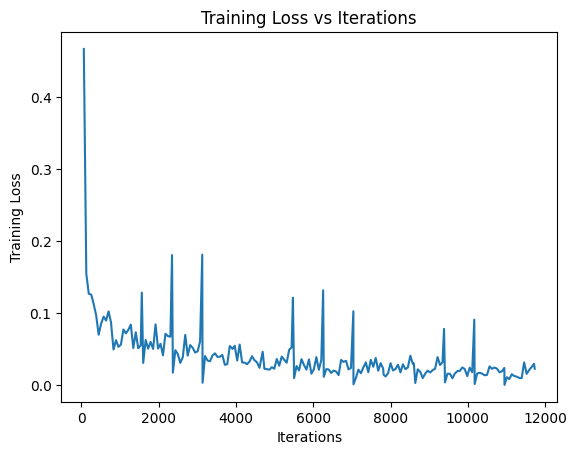

In [20]:
#plotting the loss vs iterations
plt.plot(iter_list,loss_list)

plt.xlabel('Iterations')
plt.ylabel('Training Loss')
plt.title('Training Loss vs Iterations')

### Vaidation Loss vs *Iterations*

Text(0.5, 1.0, 'Validation Loss vs Iterations')

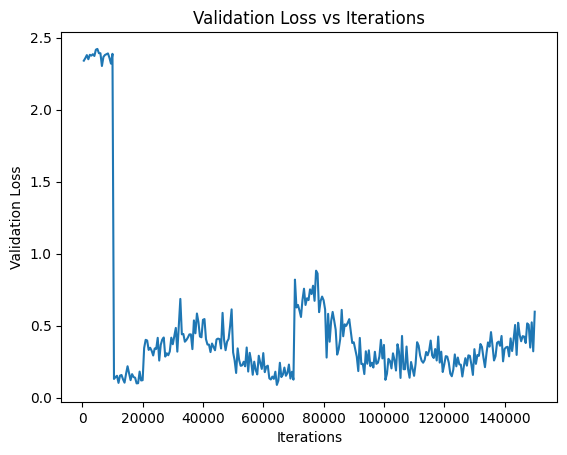

In [21]:
plt.plot(val_iter_list,val_loss_list)

plt.xlabel('Iterations')
plt.ylabel('Validation Loss')
plt.title('Validation Loss vs Iterations')

### Accuracy on Training Data

In [22]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in train_loader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = batch_net(images)
        # the class with the highest energy is what we choose as prediction
        predicted = torch.argmax(outputs, dim=1, keepdim=True)
        actual = torch.argmax(torch.squeeze(labels), dim=1, keepdim=True)
        total += labels.size(0)
        correct += (predicted == actual).sum().item()

print(f'Accuracy of the network on the 50000 training images: {100 * correct / total} %')

Accuracy of the network on the 50000 training images: 99.386 %


### Accuracy on Testing Data

In [23]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = batch_net(images)

        # the class with the highest energy is what we choose as prediction
        predicted = torch.argmax(outputs, dim=1, keepdim=True)
        actual = torch.argmax(labels, dim=1, keepdim=True)
        total += labels.size(0)
        correct += (predicted == actual).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct / total} %')

Accuracy of the network on the 10000 test images: 97.9 %


### Conclusions

We can notice that it takes this batch normalized model slightly longer to train for a certain number of epochs as compared to a model without batch normalization. But this being said, it is important to note that the model with batch normalization led to faster convergence, and hence we can attain a model of high accuracy by training it on lesser epochs compared to the standard model.
Since the accuracy is almost identical (a difference of 2 to 3 images out of every 100 images), we note that the convergence time is lesser in batch normalization

# 2. Visualising the Convolution Layer

### 1. Plotting the Conv1 Filters

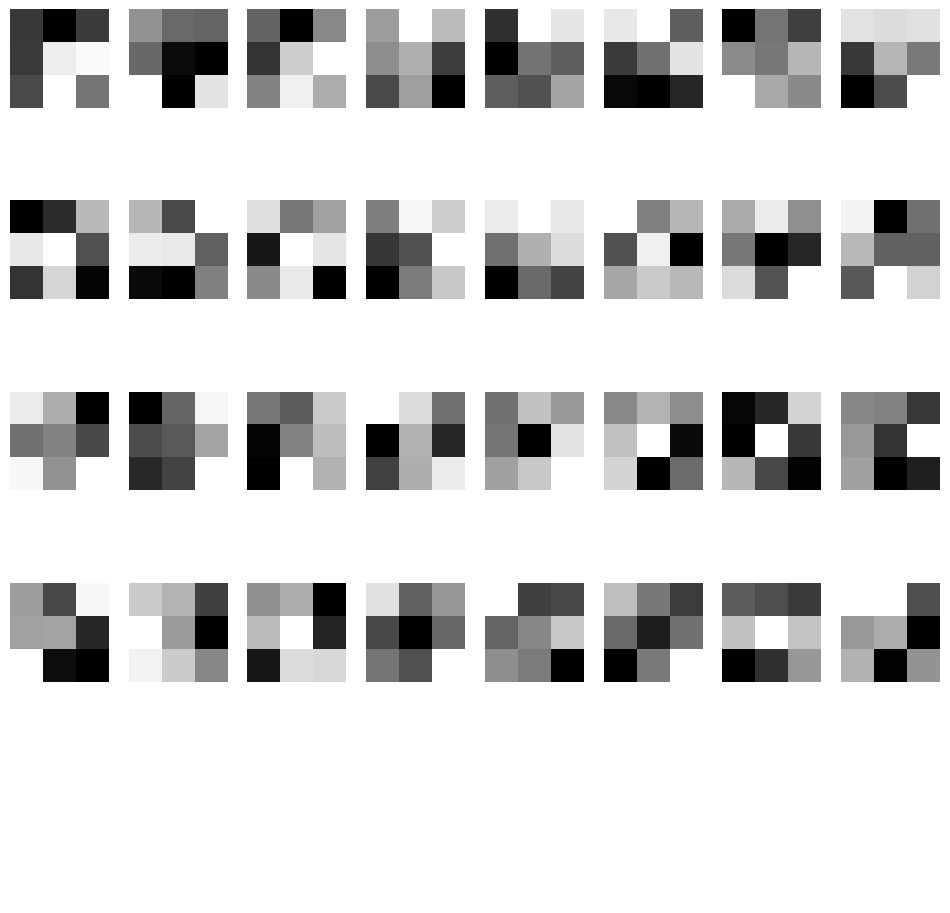

In [24]:
conv1_weights = net.conv1.weight.detach().cpu()

num_filters = conv1_weights.size(0)  # Get the number of filters
num_cols = 8  # Number of columns in the grid (you can adjust this)
num_rows = num_filters // num_cols + 1  # Calculate the number of rows

fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 12))

# Plot each filter
for i in range(num_filters):
    ax = axs[i // num_cols, i % num_cols]
    filter_i = conv1_weights[i, 0].numpy()  # Extract the i-th filter and convert to NumPy array
    ax.imshow(filter_i, cmap='gray')
    ax.axis('off')

# Hide any empty subplots
for i in range(num_filters, num_rows * num_cols):
    axs[i // num_cols, i % num_cols].axis('off')

plt.show()

#### Observations

There is no evident pattern that can be concluded from observing the filters

### 2. Plotting Conv2 Filters

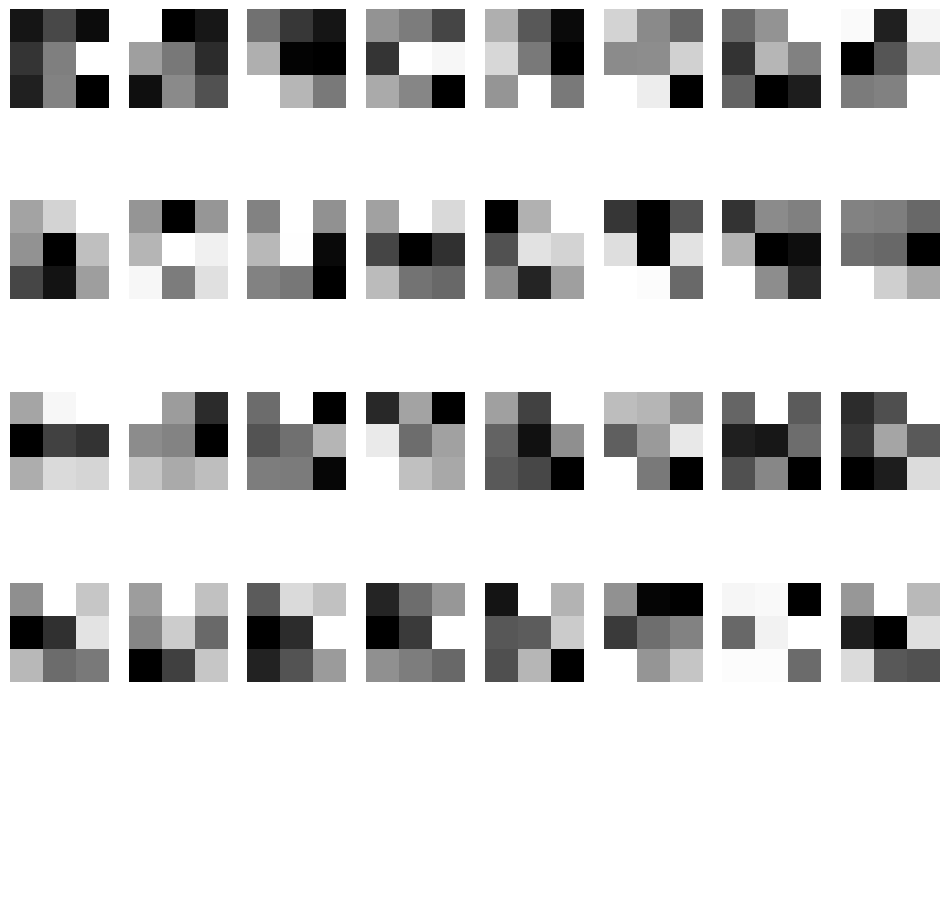

In [25]:
conv2_weights = net.conv2.weight.detach().cpu()

num_filters = conv2_weights.size(0)  # Get the number of filters
num_cols = 8  # Number of columns in the grid (you can adjust this)
num_rows = num_filters // num_cols + 1  # Calculate the number of rows

fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 12))

# Plot each filter
for i in range(num_filters):
    ax = axs[i // num_cols, i % num_cols]
    filter_i = conv2_weights[i, 0].numpy()  # Extract the i-th filter and convert to NumPy array
    ax.imshow(filter_i, cmap='gray')
    ax.axis('off')

# Hide any empty subplots
for i in range(num_filters, num_rows * num_cols):
    axs[i // num_cols, i % num_cols].axis('off')

plt.show()

#### Observations

Once again, there is no evident pattern that can be observed with the naked eye on comparing the conv1 filters and the conv2 filters

### 3. Visualising the activations of the conv layer

#### Actiavations of Conv1

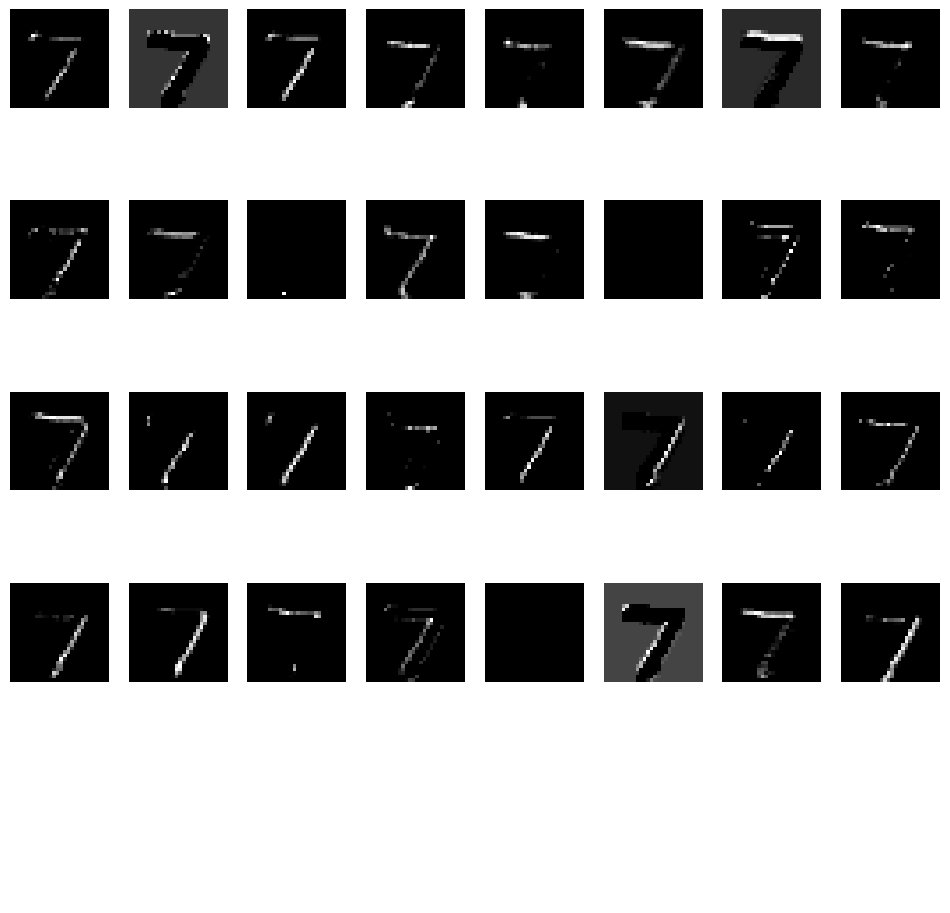

In [26]:
for data in test_loader:
    image, label = data
    output = net(image)

    conv1_activations = F.relu(net.conv1(image))  # Add batch dimension
    conv1_activations = conv1_activations.squeeze(0)  # Remove batch dimension

    # Extract individual feature maps (32 in this case)
    num_feature_maps = conv1_activations.size(0)

    # Create a grid of subplots to display the feature maps
    num_cols = 8  # Number of columns in the grid
    num_rows = num_feature_maps // num_cols + 1  # Calculate the number of rows

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 12))

    # Plot each feature map
    for i in range(num_feature_maps):
        ax = axs[i // num_cols, i % num_cols]
        feature_map_i = conv1_activations[i].cpu().detach().numpy()
        ax.imshow(feature_map_i, cmap='gray')  # You can use different colormaps
        ax.axis('off')

    # Hide any empty subplots
    for i in range(num_feature_maps, num_rows * num_cols):
        axs[i // num_cols, i % num_cols].axis('off')

    plt.show()

    break

#### Activations for Pool1

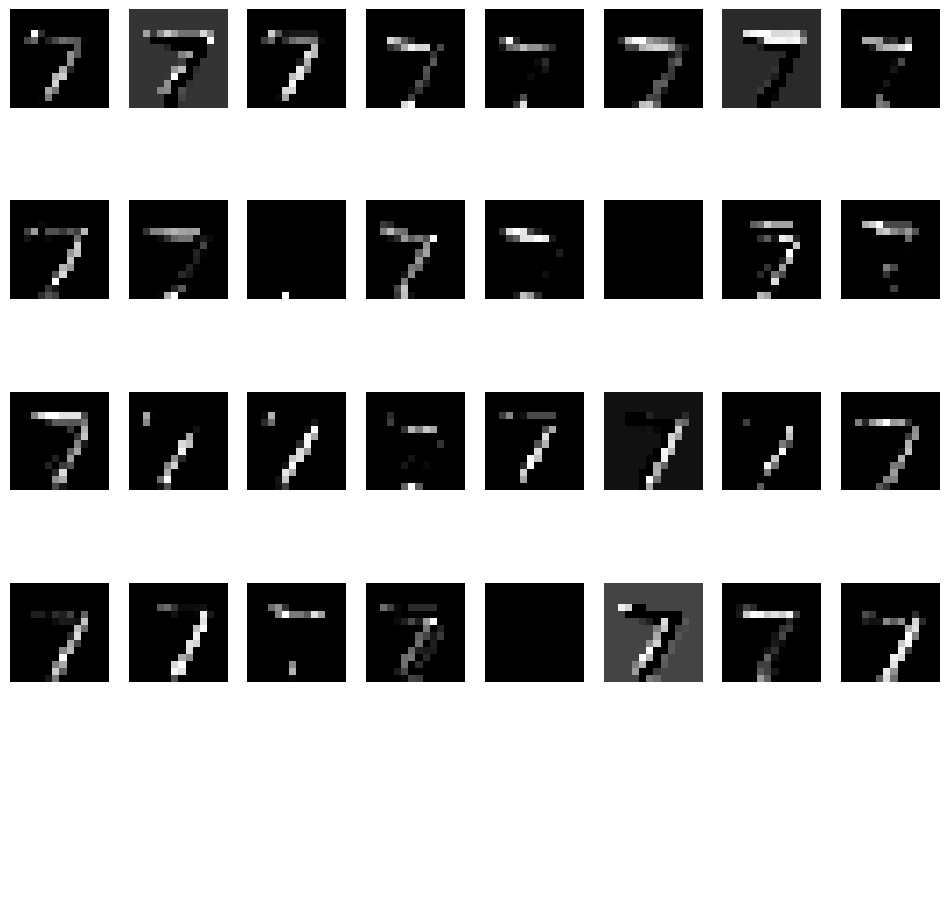

In [27]:
for data in test_loader:
    image, label = data
    output = net(image)

    pool1_output = net.pool1(F.relu(net.conv1(image)))  # Add batch dimension

    # Extract individual feature maps (32 in this case)
    num_feature_maps = pool1_output.size(1)

    # Create a grid of subplots to display the feature maps
    num_cols = 8  # Number of columns in the grid
    num_rows = num_feature_maps // num_cols + 1  # Calculate the number of rows

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 12))

    # Plot each feature map from pool1
    for i in range(num_feature_maps):
        ax = axs[i // num_cols, i % num_cols]
        feature_map_i = pool1_output[0, i].cpu().detach().numpy()  # Extract the i-th feature map
        ax.imshow(feature_map_i, cmap='gray')  # You can use different colormaps
        ax.axis('off')

    # Hide any empty subplots
    for i in range(num_feature_maps, num_rows * num_cols):
        axs[i // num_cols, i % num_cols].axis('off')

    plt.show()

    break

#### Activations of Conv2

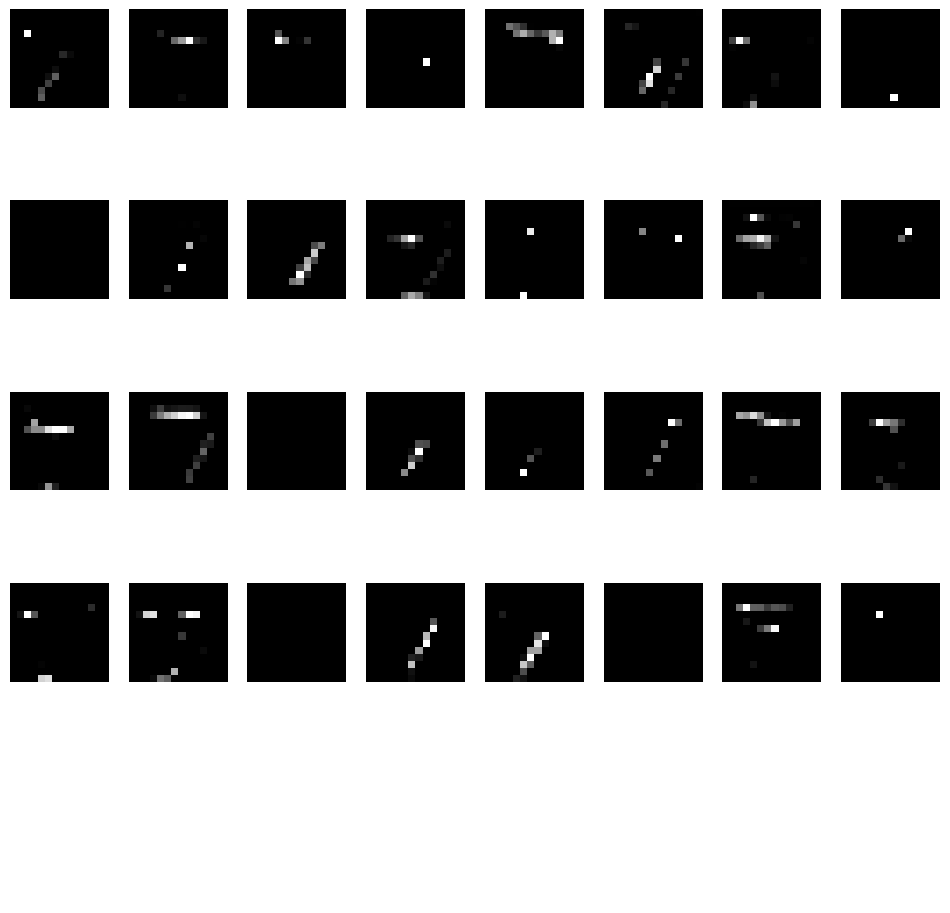

In [28]:
for data in test_loader:
    image, label = data
    output = net(image)

    conv2_output = F.relu(net.conv2(net.pool1(F.relu(net.conv1(image)))))  # Add batch dimension

    # Extract individual feature maps (32 in this case)
    num_feature_maps = conv2_output.size(1)

    # Create a grid of subplots to display the feature maps
    num_cols = 8  # Number of columns in the grid
    num_rows = num_feature_maps // num_cols + 1  # Calculate the number of rows

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 12))

    # Plot each feature map from pool1
    for i in range(num_feature_maps):
        ax = axs[i // num_cols, i % num_cols]
        feature_map_i = conv2_output[0, i].cpu().detach().numpy()  # Extract the i-th feature map
        ax.imshow(feature_map_i, cmap='gray')  # You can use different colormaps
        ax.axis('off')

    # Hide any empty subplots
    for i in range(num_feature_maps, num_rows * num_cols):
        axs[i // num_cols, i % num_cols].axis('off')

    plt.show()

    break

#### Activations of Pool2

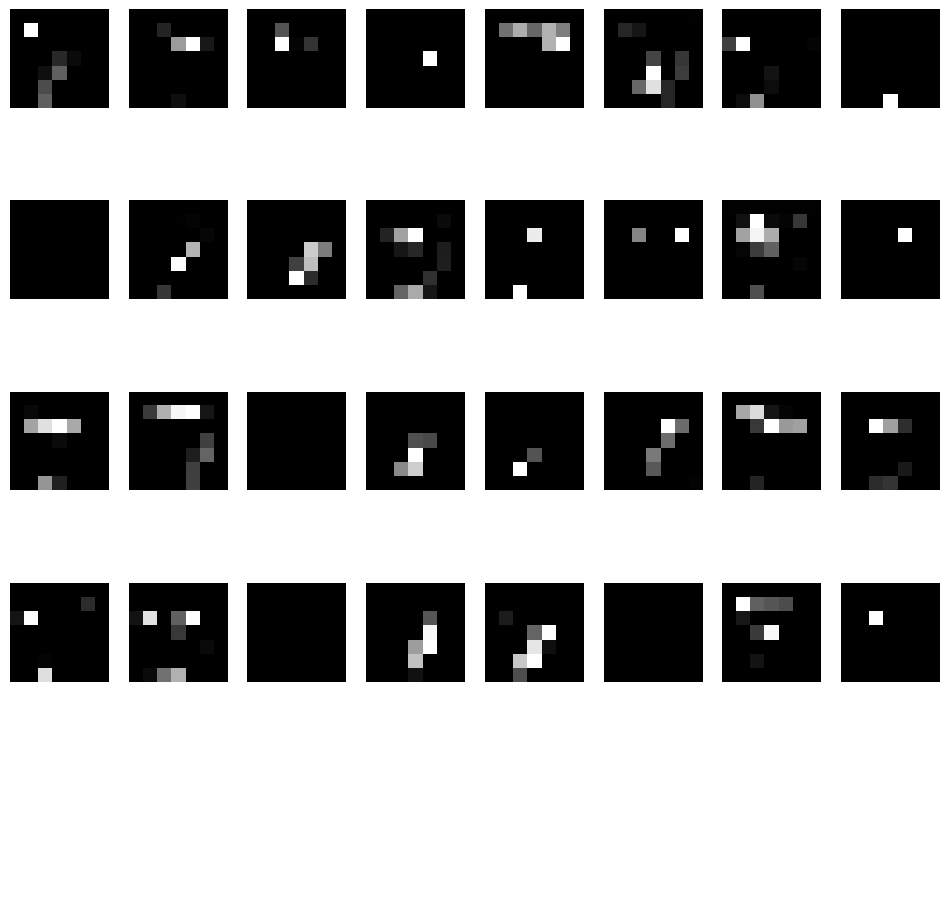

In [29]:
for data in test_loader:
    image, label = data
    output = net(image)

    pool2_output = net.pool1(F.relu(net.conv2(net.pool1(F.relu(net.conv1(image))))))  # Add batch dimension

    # Extract individual feature maps (32 in this case)
    num_feature_maps = pool2_output.size(1)

    # Create a grid of subplots to display the feature maps
    num_cols = 8  # Number of columns in the grid
    num_rows = num_feature_maps // num_cols + 1  # Calculate the number of rows

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 12))

    # Plot each feature map from pool1
    for i in range(num_feature_maps):
        ax = axs[i // num_cols, i % num_cols]
        feature_map_i = pool2_output[0, i].cpu().detach().numpy()  # Extract the i-th feature map
        ax.imshow(feature_map_i, cmap='gray')  # You can use different colormaps
        ax.axis('off')

    # Hide any empty subplots
    for i in range(num_feature_maps, num_rows * num_cols):
        axs[i // num_cols, i % num_cols].axis('off')

    plt.show()

    break

#### Observations

We can observe that:
- Every pooling layer reduced the number of pixels in the image by half, making the image more grainy
- The first conv layer gives us 32 modifications of the input image, whereas the second conv layer essentially extracts the features of the original input image

## 3. Occlusion

Occluding a kernel of 10 random images

### Kernel Sliding

Here we are moving a kernel over the image and occluding that part of the image. We then observe the plot of the intensity of the class which it is supposed to predict and plot that as a colour map

In [30]:
occluder_size = 3
pad = 1
out_size = 28-occluder_size+2*pad+1
vert_start = 0
vert_end = 0
horiz_start = 0
horiz_end = 0
results = torch.zeros([10,28,28])
grid = torch.zeros([784, 28, 28])
labels = torch.zeros([10])
# grid = torch.zeros([4,28,28])
# grid1 = torch.zeros([4,28,28])

random_indices = random.sample(range(len(test_data)), 10)
sampler = SubsetRandomSampler(random_indices)
subset_loader = DataLoader(test_data, batch_size=1, sampler=sampler)

i = 0
for data in subset_loader:
    image, label = data
    img_pad = np.pad(image,((0,0),(0,0),(1,1),(1,1)), mode='constant', constant_values = (0,0))

    labels[i]=torch.argmax(label)
    for h in range (out_size):
        vert_start = h
        vert_end = h+3

        for w in range (out_size):
            horiz_start = w
            horiz_end = w+3

            temp = image.clone()

            temp[0,0,vert_start:vert_end, horiz_start:horiz_end] = 0

            output = net(temp)
            intensity = torch.max(output)
            results[i,h,w]=intensity.item()
    i+=1


### Plotting the colour map

Here we plot the colour map of the intensity of the predicted class as we move the occluded region accross the image

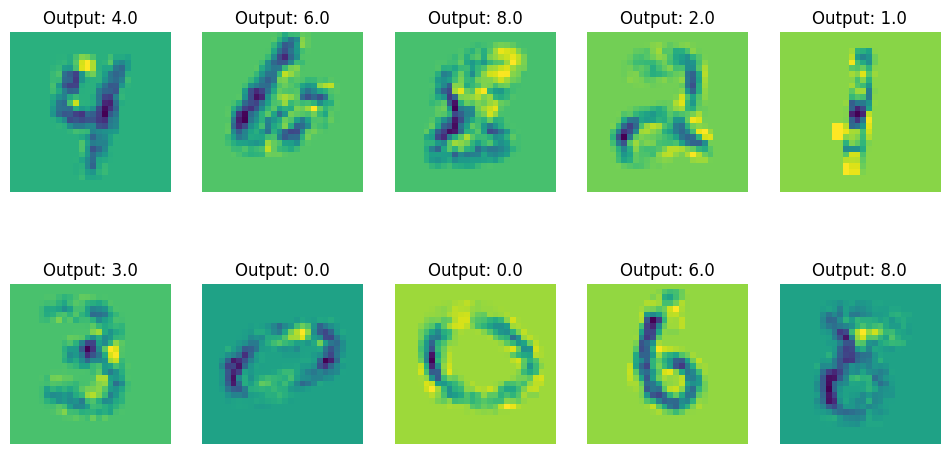

In [31]:
fig, axs = plt.subplots(2, 5, figsize=(12, 6))

for i in range(10):
    ax = axs[i // 5, i % 5]
    filter_i = results[i,:,:].detach().numpy()  # Extract the i-th filter and convert to NumPy array
    ax.imshow(filter_i, cmap='viridis')
    ax.set_title(f"Output: {labels[i]}")
    ax.axis('off')

plt.show()

### Observations

We observe that the intensity of the predicted class is clearly lower when the occluded region is right over the salient features of the digit. This indicates that the model does make its predictions based on the features of the digit, and not any additional backgorund information

# 3. Adversarial Examples

## 3.1 Non-Targetted Attack

### Building the image generation model

In [32]:
# Choose a target class (0 to 9)
target_class = 3

# Initialize the input tensor as Gaussian noise centered around 128
X = torch.randn(1, 1, 28, 28) + 128
X.requires_grad = True

# Set the step size for gradient ascent
step_size = 1.0
num_iterations = 5000

cost_history = []

criterion = nn.CrossEntropyLoss()

for iteration in range(num_iterations):
    # Forward pass
    logits = net(X)

    # Compute the cost function (logit for the target class)
    cost = logits[0, target_class]

    # Store the cost for plotting
    cost_history.append(cost.item())

    net.zero_grad()  # Clear gradients from the model
    X.grad = None  # Clear gradients from the input image
    cost.backward()  # Compute gradients with respect to the input image

    # Update the input image using gradient ascent
    X.data += step_size * X.grad.data

### 1. Plotting the generated image

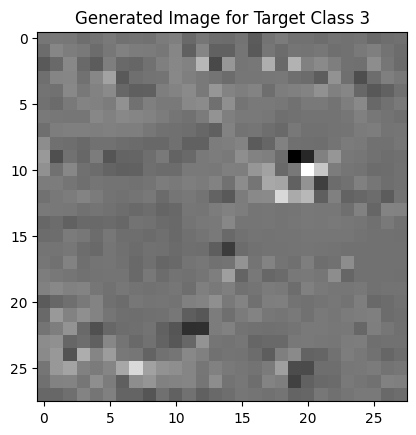

Predicted Class: 3 (Target Class: 3)


In [33]:
# Display the generated image
plt.figure()
plt.imshow(X.view(28, 28).detach().numpy(), cmap='gray')
plt.title(f'Generated Image for Target Class {target_class}')
plt.show()

# Evaluate the network's prediction for the generated image
logits = net(X)
predicted_class = torch.argmax(logits).item()
print(f'Predicted Class: {predicted_class} (Target Class: {target_class})')

### 2. Prediction Confidence

The model predicts the generated image's class correctly mojority of the time.

### 3. Resembelance with actual digit

The image does not very evidently resemble the actual digit, though some similarities can be observed. This could be due to the complexity of the model. The model being deep and having been trained to identify certain patterns and features to detect a digit, may only be able to generate that in the generated image


### 4. Cost Function

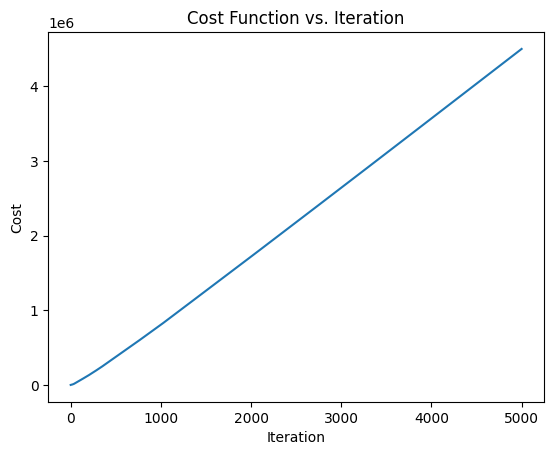

In [34]:
# Plot the cost function
plt.figure()
plt.plot(cost_history)
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.title('Cost Function vs. Iteration')
plt.show()

The cost function is evidently increasing as we are performing gradient ascent

## 3.2 Targetted Attack

### Creating a subset of images of each digit

In [35]:
#loading targets
target_images = torch.randn(10, 1, 1, 28, 28)
i = 0
for data in test_loader:
    image,label = data
    if (torch.argmax(label).item()==i):
        target_images[i]=image
        i+=1
    if(i==10):
        break


### Building the image generation model

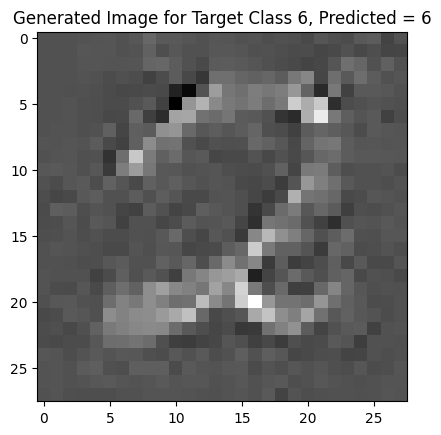

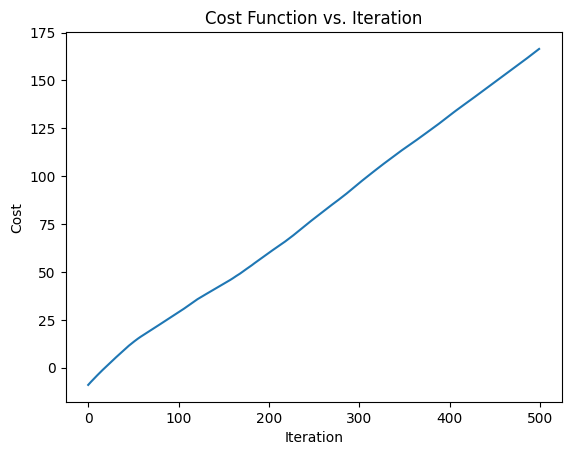

In [37]:
# Initialize the input tensor as Gaussian noise centered around 128
input_image = target_images[2].clone()
input_image.requires_grad = True  # We need gradients with respect to the input

# Set the step size for gradient ascent
step_size = 0.001  # Small step size

# Define the number of gradient ascent iterations
num_iterations = 500
beta = 0.001

# Create a list to store cost values for plotting
cost_history = []

# Define the MSE loss function
mse_criterion = nn.MSELoss()

target_class = 6
# Gradient ascent loop
target_image =  target_images[target_class].clone()  # Example: Random noise as target

# Gradient ascent with MSE regularization
for iteration in range(num_iterations):
    # Forward pass through the network
    logits = net(input_image)

    # Compute the cost function
    logit_cost = logits[0, target_class]
    mse_cost = mse_criterion(input_image, target_image)
    cost = logit_cost - beta * mse_cost  # Beta = 0.001 (tune as needed)

    # Store the cost for plotting
    cost_history.append(cost.item())

    # Backpropagation
    net.zero_grad()  # Clear gradients from the model
    input_image.grad = None  # Clear gradients from the input image
    cost.backward()  # Compute gradients with respect to the input image

    # Update the input image using gradient ascent
    input_image.data += step_size * input_image.grad.data

    # Reset gradients
    input_image.grad.zero_()

# Display the generated image for the current class
logits = net(input_image)
predicted_class = torch.argmax(logits).item()
plt.figure()
plt.imshow(input_image.view(28, 28).detach().numpy(), cmap='gray')
plt.title(f'Generated Image for Target Class {target_class}, Predicted = {predicted_class}')
plt.show()

# Plot the cost function
plt.figure()
plt.plot(cost_history)
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.title('Cost Function vs. Iteration')
plt.show()

We can observe that the image generated looks like a 2, but has been predicted as 6

# Resources

https://pytorch.org/tutorials/ - Most of the resources used as assistance were various pages in the official pytorch documentation